## The purpose of this project is to predict taxi cab fares before each ride

**Column name** - Description

**ID** - Trip identification number

**VendorID** - A code indicating the TPEP provider that provided the record.  

- 1= Creative Mobile Technologies, LLC; 

- 2= VeriFone Inc.

**tpep_pickup_datetime** - The date and time when the meter was engaged. 

**tpep_dropoff_datetime** - The date and time when the meter was disengaged. 

**Passenger_count** - The number of passengers in the vehicle.  
- This is a driver-entered value.

**Trip_distance** - The elapsed trip distance in miles reported by the taximeter.

**PULocationID** - TLC Taxi Zone in which the taximeter was engaged

**DOLocationID** - TLC Taxi Zone in which the taximeter was disengaged

**RateCodeID** - The final rate code in effect at the end of the trip. 

- 1 = Standard rate 

- 2=JFK 

- 3=Newark 

- 4=Nassau or Westchester 

- 5=Negotiated fare 

- 6=Group ride

**Store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before being sent to the vendor, aka “store and forward,”  because the vehicle did not have a connection to the server. 

- Y (1) = store and forward trip 

- N(0) = not a store and forward trip

**Payment_type** - A numeric code signifying how the passenger paid for the trip.  

- 1= Credit card 

- 2= Cash 

- 3= No charge 

- 4= Dispute 

- 5= Unknown 

- 6= Voided trip

**Fare_amount** - The time-and-distance fare calculated by the meter.

**Extra** - Miscellaneous extras and surcharges. Currently, this only includes the $0.50 and $1 rush hour and overnight charges.

**MTA_tax** - $0.50 MTA tax that is automatically triggered based on the metered rate in use.

**Improvement_surcharge** - $0.30 improvement surcharge assessed trips at the flag drop. The  improvement surcharge began being levied in 2015.

**Tip_amount** - Tip amount – This field is automatically populated for credit card tips. Cash tips are not included.

**Tolls_amount** - Total amount of all tolls paid in trip. 

**Total_amount** - The total amount charged to passengers. Does not include cash tips.

In [2]:
import pandas as pd               
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import seaborn as sns 

In [3]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn import metrics

import joblib


In [4]:
#load the dataset
df = pd.read_csv('2017_Yellow_Taxi_Trip_Data.csv')


In [5]:
# view the first 5 rows
df.head()

,Unnamed: 0,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,24870114,2,03/25/2017 8:55:43 AM,03/25/2017 9:09:47 AM,6,3.34,1,N,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56
1,35634249,1,04/11/2017 2:53:28 PM,04/11/2017 3:19:58 PM,1,1.80,1,N,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80
2,106203690,1,12/15/2017 7:26:56 AM,12/15/2017 7:34:08 AM,1,1.00,1,N,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75
3,38942136,2,05/07/2017 1:17:59 PM,05/07/2017 1:48:14 PM,1,3.70,1,N,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69
4,30841670,2,04/15/2017 11:32:20 PM,04/15/2017 11:49:03 PM,1,4.37,1,N,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Unnamed: 0             22699 non-null  int64  
 1   VendorID               22699 non-null  int64  
 2   tpep_pickup_datetime   22699 non-null  object 
 3   tpep_dropoff_datetime  22699 non-null  object 
 4   passenger_count        22699 non-null  int64  
 5   trip_distance          22699 non-null  float64
 6   RatecodeID             22699 non-null  int64  
 7   store_and_fwd_flag     22699 non-null  object 
 8   PULocationID           22699 non-null  int64  
 9   DOLocationID           22699 non-null  int64  
 10  payment_type           22699 non-null  int64  
 11  fare_amount            22699 non-null  float64
 12  extra                  22699 non-null  float64
 13  mta_tax                22699 non-null  float64
 14  tip_amount             22699 non-null  float64
 15  to

In [7]:
# convert date and time columns to datetime data type
df['tpep_pickup_datetime'] = pd.to_datetime(df['tpep_pickup_datetime'])
df['tpep_dropoff_datetime'] = pd.to_datetime(df['tpep_dropoff_datetime'])

In [8]:
# rename 'Unnamed: 0' column to id
df.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [10]:
df['store_and_fwd_flag'].value_counts()

store_and_fwd_flag
N    22600
Y       99
Name: count, dtype: int64

In [11]:
# Encode categorical variables
df['store_and_fwd_flag'] = df['store_and_fwd_flag'].map({'N': 0, 'Y': 1})

In [12]:
# Calculate the duration in minutes
df['duration'] = ((df['tpep_dropoff_datetime'] - df['tpep_pickup_datetime']) / np.timedelta64(1,'m')).round(2)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22699 entries, 0 to 22698
Data columns (total 19 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     22699 non-null  int64         
 1   VendorID               22699 non-null  int64         
 2   tpep_pickup_datetime   22699 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22699 non-null  datetime64[ns]
 4   passenger_count        22699 non-null  int64         
 5   trip_distance          22699 non-null  float64       
 6   RatecodeID             22699 non-null  int64         
 7   store_and_fwd_flag     22699 non-null  int64         
 8   PULocationID           22699 non-null  int64         
 9   DOLocationID           22699 non-null  int64         
 10  payment_type           22699 non-null  int64         
 11  fare_amount            22699 non-null  float64       
 12  extra                  22699 non-null  float64       
 13  m

In [14]:
#statistical description of the data
df.describe().T

,count,mean,min,25%,50%,75%,max,std
id,22699.0,56758486.171285,12127.0,28520556.0,56731504.0,85374524.0,113486300.0,32744929.492148
VendorID,22699.0,1.556236,1.0,1.0,2.0,2.0,2.0,0.496838
tpep_pickup_datetime,22699,2017-06-29 07:32:48.973126656,2017-01-01 00:08:25,2017-03-30 03:09:38.500000,2017-06-23 12:35:57,2017-10-02 10:34:34,2017-12-31 23:45:30,NaN
tpep_dropoff_datetime,22699,2017-06-29 07:49:49.799726848,2017-01-01 00:17:20,2017-03-30 03:11:20.500000,2017-06-23 12:55:11,2017-10-02 10:53:47,2017-12-31 23:49:24,NaN
passenger_count,22699.0,1.642319,0.0,1.0,1.0,2.0,6.0,1.285231
trip_distance,22699.0,2.913313,0.0,0.99,1.61,3.06,33.96,3.653171
RatecodeID,22699.0,1.043394,1.0,1.0,1.0,1.0,99.0,0.708391
store_and_fwd_flag,22699.0,0.004361,0.0,0.0,0.0,0.0,1.0,0.065898
PULocationID,22699.0,162.412353,1.0,114.0,162.0,233.0,265.0,66.633373
DOLocationID,22699.0,161.527997,1.0,112.0,162.0,233.0,265.0,70.139691


**passenger_count**
- it has a mean of 1.64, indicating most rides have 1 or 2 passengers.
- The maximum value is 6, which seems reasonable.

**trip_distance:**
- it has a Mean of 2.91 miles, with a wide range (0 to 33.96 miles).
- it has a maximum of 33.96 miles, which might be an outlier considering the 75th % is 3.06 miles 

**RatecodeID:**
- it has a mean of 1.04, indicating that most trips are likely to be standard rate (RatecodeID 1).
- The maximum value is 99, which might be an error (since the RatecodeID can only be from 1 to 6)

**store_and_fwd_flag:**
- Mean: 0.004, indicating that the flag is rarely set to 'Y' (almost always 'N').


**payment_type:**

- Mean: 1.34, suggesting most payments are of type 1 (credit card).
- There are four payment types (1 to 4) in the data.

**fare_amount:**
- Mean: $13.03, but with a very wide range and some outliers (minimum of -120 and maximum of 999.99).
- same with tip_amount, tolls_amount, :

Reasonable values, but some negative values in the minimum of **extra, improvement_surcharge, and mta_tax** indicate potential data errors.

**total_amount:**
- Mean: $16.31, with outliers (minimum of -120.3 and maximum of 1200.29).

In [15]:
df['passenger_count'].value_counts().reset_index()

,passenger_count,count
0,1,16117
1,2,3305
2,5,1143
3,3,953
4,6,693
5,4,455
6,0,33


about 70% of the rides were single occupancy, though there were still nearly 700 rides with as many as six passengers. 

Also, there are 33 rides with an occupancy count of zero, which doesn't make sense. These would likely be dropped unless a reasonable explanation can be found for them.

In [16]:
df[df['passenger_count'] == 0].head()

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
1516,96563556,1,2017-11-14 15:45:23,2017-11-14 16:26:38,0,8.8,1,0,138,164,1,33.0,0.0,0.5,5.55,5.76,0.3,45.11,41.25
1874,102273749,1,2017-12-03 12:05:52,2017-12-03 12:13:51,0,1.1,1,0,48,237,2,7.0,0.0,0.5,0.00,0.00,0.3,7.80,7.98
1925,75654951,1,2017-09-09 03:44:45,2017-09-09 03:49:19,0,0.8,1,0,48,48,2,5.0,0.5,0.5,0.00,0.00,0.3,6.30,4.57
3352,107464306,1,2017-12-18 22:44:57,2017-12-18 23:00:24,0,2.7,1,0,87,79,1,12.5,0.5,0.5,2.75,0.00,0.3,16.55,15.45
4060,100326273,1,2017-11-27 13:08:01,2017-11-27 13:17:55,0,1.7,1,0,161,239,1,9.0,0.0,0.5,1.95,0.00,0.3,11.75,9.90


### OUTLIERS

Keeping in mind that many of the features will not be used to fit your model, the most important columns to check for outliers are likely to be:

- trip_distance
- fare_amount
- duration

#### trip_distance

In [17]:
# funcion to visualize boxplot, and histogram with KDE
def visualize_distribution(data, column_name):
    """
    Visualize the distribution of a column using boxplot and histogram with KDE.
    
    Parameters:
        data (DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to visualize.
    """
    # Set up the matplotlib figure
    # Create subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Boxplot
    sns.boxplot(x=data[column_name], ax=axes[0])
    axes[0].set_title(f'Boxplot of {column_name}')
    
     # Add a red triangle marker for the mean
    mean_value = data[column_name].mean()
    axes[0].scatter(mean_value, 0, color='red', marker='^', s=100, label='Mean')
    
    # Histogram with KDE
    sns.histplot(data[column_name], kde=True, ax=axes[1])
    axes[1].set_title(f'Histogram with KDE of {column_name}')
    
    # Adjust layout
    plt.tight_layout()
    
    # Show plot
    plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


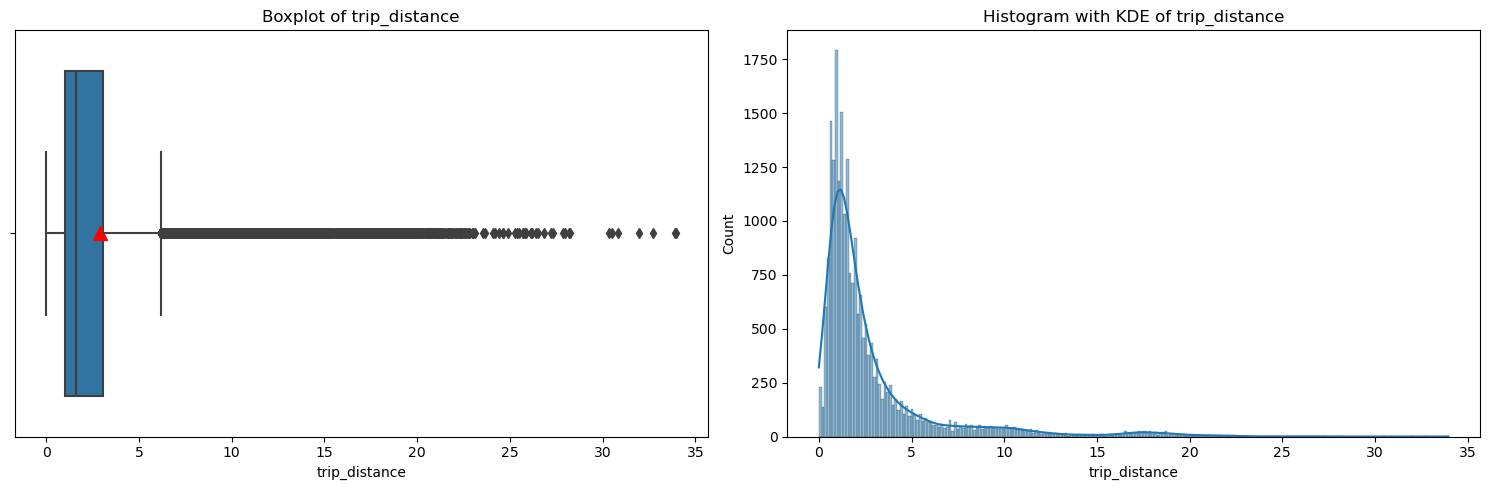

In [18]:
#visualaziation  of Trip Distance
visualize_distribution(df, 'trip_distance')

- The majority of trips were journeys of 0-5 miles. 
- The number of trips falls away steeply as the distance traveled increases beyond that.
- the distribution is right skewed

The distance between 2 places can be up to 30 miles and that also depends on the routes.

With this knowledge and the distribution of the values in the `trip_distance` column, it's reasonable to leave these values alone and not alter them. 

but lets look at the trip distance of 0

In [19]:
(df['trip_distance'] == 0).sum()

148

In [20]:
df[df['trip_distance'] == 0].head(10)

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
128,52987734,1,2017-06-22 08:05:33,2017-06-22 08:05:40,1,0.0,3,0,231,231,2,20.0,0.0,0.0,0.00,0.00,0.3,20.30,0.12
246,78660848,1,2017-09-18 20:50:53,2017-09-18 20:51:03,1,0.0,1,0,145,145,2,2.5,0.5,0.5,0.00,0.00,0.3,3.80,0.17
291,83480088,1,2017-10-04 19:46:24,2017-10-04 19:46:50,1,0.0,1,0,132,132,2,2.5,1.0,0.5,0.00,0.00,0.3,4.30,0.43
319,14024301,1,2017-02-22 04:01:44,2017-02-22 04:01:53,1,0.0,1,0,90,90,3,2.5,0.5,0.5,0.00,0.00,0.3,3.80,0.15
424,3767951,1,2017-01-14 07:00:26,2017-01-14 07:00:53,1,0.0,1,0,208,208,1,2.5,0.0,0.5,6.70,0.00,0.3,10.00,0.45
470,103583013,2,2017-12-07 14:39:18,2017-12-07 14:39:23,1,0.0,5,0,138,138,1,34.0,0.0,0.5,6.96,0.00,0.3,41.76,0.08
472,52474677,1,2017-06-20 18:57:39,2017-06-20 18:57:39,1,0.0,1,0,162,264,2,9.5,1.0,0.5,0.00,0.00,0.3,11.30,0.00
572,61050418,2,2017-07-18 13:29:06,2017-07-18 13:29:19,1,0.0,2,0,230,161,1,52.0,0.0,0.5,11.71,5.76,0.3,70.27,0.22
647,20816132,1,2017-03-12 22:28:27,2017-03-12 22:28:30,1,0.0,1,0,143,143,1,2.5,0.5,0.5,3.00,0.00,0.3,6.80,0.05
795,101135030,1,2017-11-30 07:11:34,2017-11-30 07:11:34,1,0.0,1,0,246,264,2,8.0,0.0,0.5,0.00,0.00,0.3,8.80,0.00


#### `trip_distance` outliers

You know from the summary statistics that there are trip distances of 0. Are these reflective of erroneous data, or are they very short trips that get rounded down?

To check, sort the column values, eliminate duplicates, and inspect the least 10 values. Are they rounded values or precise values?

In [21]:
# Are trip distances of 0 bad data or very short trips rounded down?
sorted(set(df['trip_distance']))[:10]

[0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09]

The distances are captured with a high degree of precision. However, it might be possible for trips to have distances of zero if a passenger summoned a taxi and then changed their mind. Besides, are there enough zero values in the data to pose a problem?


148 out of ~23,000 rides is relatively insignificant. we could delete the rows or cjange the values to 0.01 but it's unlikely to have much of an effect on the model. Therefore, the `trip_distance` column will remain untouched with regard to outliers.

#### `fare_amount` outliers

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


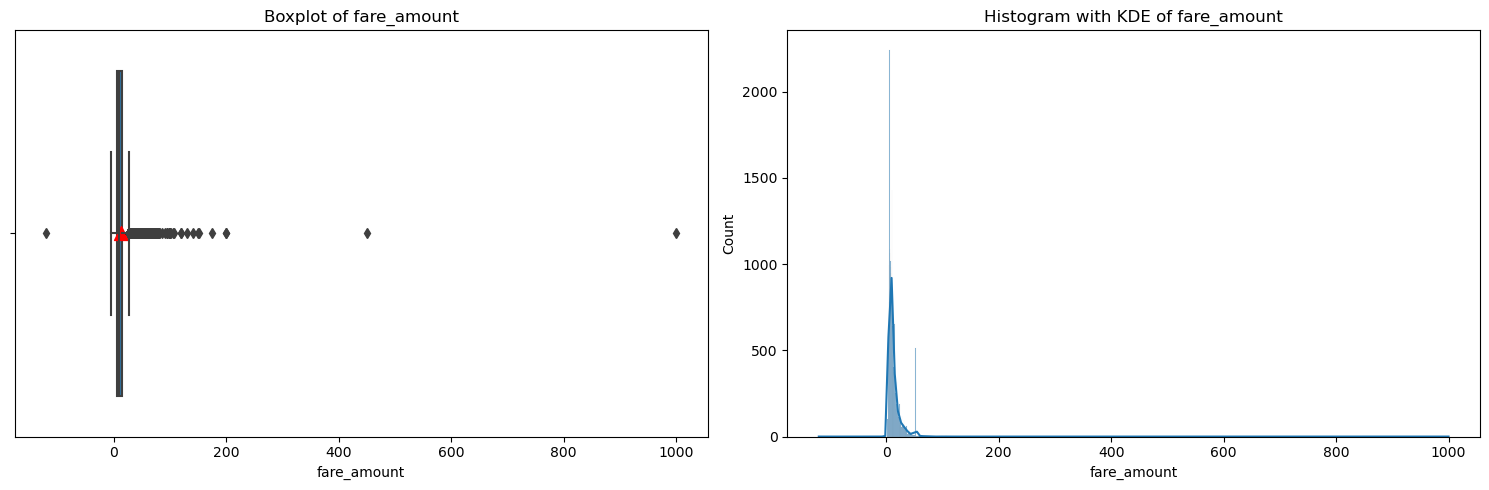

In [22]:
#visualaziation  of Fare Amount
visualize_distribution(df, 'fare_amount')

In [23]:
df[['fare_amount']].describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,22699.0,13.026629,13.243791,-120.0,6.5,9.5,14.5,999.99


The range of values in the `fare_amount` column is large and the extremes don't make much sense.

* **Low values:** Negative values are problematic. 
- lets view the negative values
- Values of zero could be legitimate if the taxi logged a trip that was immediately canceled.

* **High values:** The maximum fare amount in this dataset is nearly \\$1,000, which seems very unlikely. 

- High values for this feature can be capped based on intuition and statistics. 
- The interquartile range (IQR) is \\$8. The standard formula of `Q3 + (1.5 * IQR)` yields \$26.50. That doesn't seem appropriate for the maximum fare cap. In this case, we'll use a factor of `6`, which results in a cap of $62.50.


In [24]:
(df['fare_amount'] < 0).sum()

14

In [25]:
df[df['fare_amount'] < 0]

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
314,105454287,2,2017-12-13 02:02:39,2017-12-13 02:03:08,6,0.12,1,0,161,161,3,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.48
1646,57337183,2,2017-07-05 11:02:23,2017-07-05 11:03:00,1,0.04,1,0,79,79,3,-2.5,0.0,-0.5,0.0,0.0,-0.3,-3.3,0.62
4423,97329905,2,2017-11-16 20:13:30,2017-11-16 20:14:50,2,0.06,1,0,237,237,4,-3.0,-0.5,-0.5,0.0,0.0,-0.3,-4.3,1.33
5448,28459983,2,2017-04-06 12:50:26,2017-04-06 12:52:39,1,0.25,1,0,90,68,3,-3.5,0.0,-0.5,0.0,0.0,-0.3,-4.3,2.22
5758,833948,2,2017-01-03 20:15:23,2017-01-03 20:15:39,1,0.02,1,0,170,170,3,-2.5,-0.5,-0.5,0.0,0.0,-0.3,-3.8,0.27
8204,91187947,2,2017-10-28 20:39:36,2017-10-28 20:41:59,1,0.41,1,0,236,237,3,-3.5,-0.5,-0.5,0.0,0.0,-0.3,-4.8,2.38
10281,55302347,2,2017-06-05 17:34:25,2017-06-05 17:36:29,2,0.00,1,0,238,238,4,-2.5,-1.0,-0.5,0.0,0.0,-0.3,-4.3,2.07
11204,58395501,2,2017-07-09 07:20:59,2017-07-09 07:23:50,1,0.64,1,0,50,48,3,-4.5,0.0,-0.5,0.0,0.0,-0.3,-5.3,2.85
12944,29059760,2,2017-04-08 00:00:16,2017-04-08 23:15:57,1,0.17,5,0,138,138,4,-120.0,0.0,0.0,0.0,0.0,-0.3,-120.3,1395.68
14714,109276092,2,2017-12-24 22:37:58,2017-12-24 22:41:08,5,0.40,1,0,164,161,4,-4.0,-0.5,-0.5,0.0,0.0,-0.3,-5.3,3.17


negative values arent much and they dont make sense so they will be deleted

In [26]:
# deleting the rows with fare amount < 0
df = df[df['fare_amount'] >= 0]

In [27]:
bshape = df.shape
print(f"df shape: {bshape}")

# Calculate the quartiles
Q1 = df['fare_amount'].quantile(0.25)
Q3 = df['fare_amount'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper cap using a factor of 6
upper_cap = Q3 + 6 * IQR

# Printing the upper cap for fare_amount
print(f"Upper Cap for fare_amount: {upper_cap}")

# Delete rows where fare_amount is greater than the upper cap
df = df[df['fare_amount'] <= upper_cap]

ashape = df.shape
print(f"df shape: {ashape}")

df shape: (22685, 19)
Upper Cap for fare_amount: 62.5
df shape: (22603, 19)


In [28]:
df[['fare_amount']].describe().T

,count,mean,std,min,25%,50%,75%,max
fare_amount,22603.0,12.725953,10.125646,0.0,6.5,9.5,14.5,62.5


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


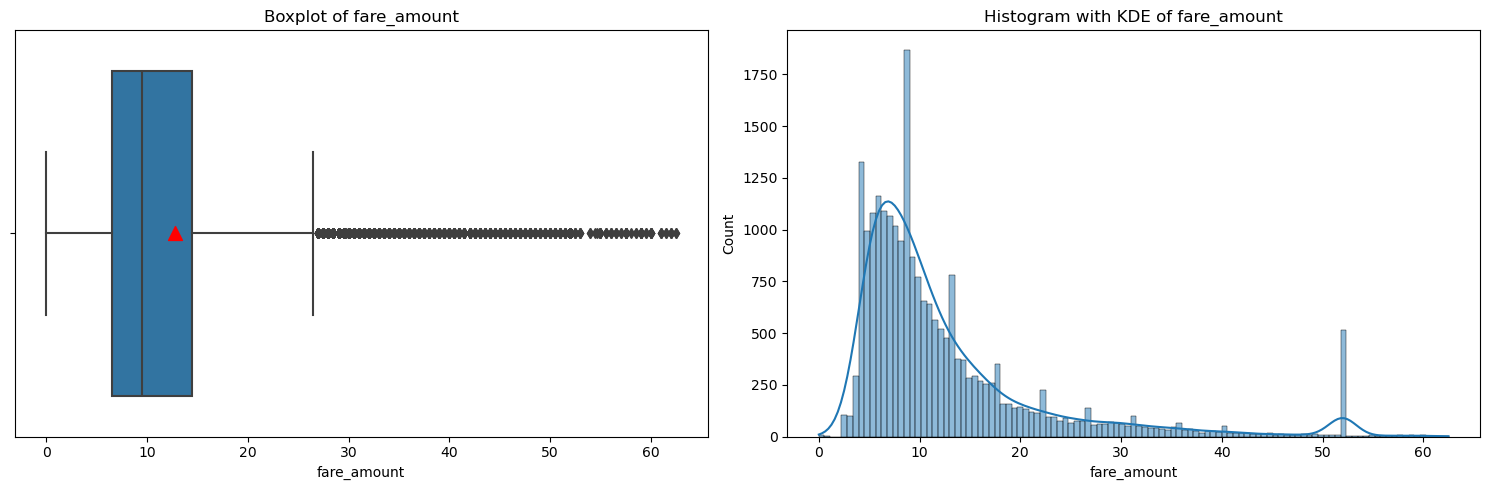

In [29]:
#visualaziation  of new Fare Amount
visualize_distribution(df, 'fare_amount')

#### duration

In [30]:
df[['duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,22603.0,16.870558,61.399204,-16.98,6.65,11.17,18.28,1439.55


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


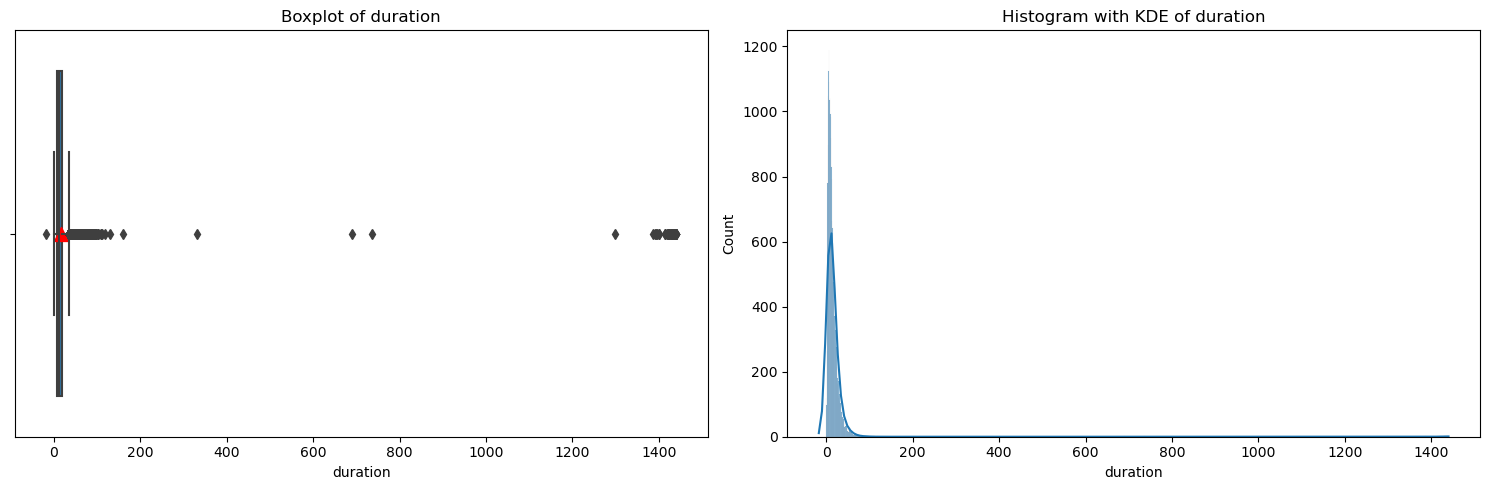

In [31]:
visualize_distribution(df, 'duration')

In [32]:
df[df['duration'] < 0]

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
9356,93542707,1,2017-11-05 01:23:08,2017-11-05 01:06:09,1,5.7,1,0,161,157,3,28.0,0.5,0.5,0.0,0.0,0.3,29.3,-16.98


The `duration` column has problematic values at both the lower and upper extremities.

* **Low values:** There should be no values that represent negative time. delete all negative durations with `0`.

* **High values:** Impute high values the same way you imputed the high-end outliers for fares: `Q3 + (6 * IQR)`.

In [33]:
# deleting rows that are less than 0 (-ve duration values)
df = df[df['duration'] >= 0]

In [34]:
bshape = df.shape
print(f"df shape: {bshape}")

# Calculate the quartiles
Q1 = df['duration'].quantile(0.25)
Q3 = df['duration'].quantile(0.75)

# Calculate the interquartile range (IQR)
IQR = Q3 - Q1

# Calculate the upper cap using a factor of 6
upper_cap = Q3 + 6 * IQR

# Printing the upper cap for duration
print(f"Upper Cap for duration: {upper_cap}")

# Delete rows where duration is greater than the upper cap
df = df[df['duration'] <= upper_cap]

ashape = df.shape
print(f"df shape: {ashape}")

df shape: (22602, 19)
Upper Cap for duration: 88.06
df shape: (22536, 19)


In [35]:
df[['duration']].describe().T

,count,mean,std,min,25%,50%,75%,max
duration,22536.0,14.154867,11.078237,0.0,6.65,11.13,18.2,87.95


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


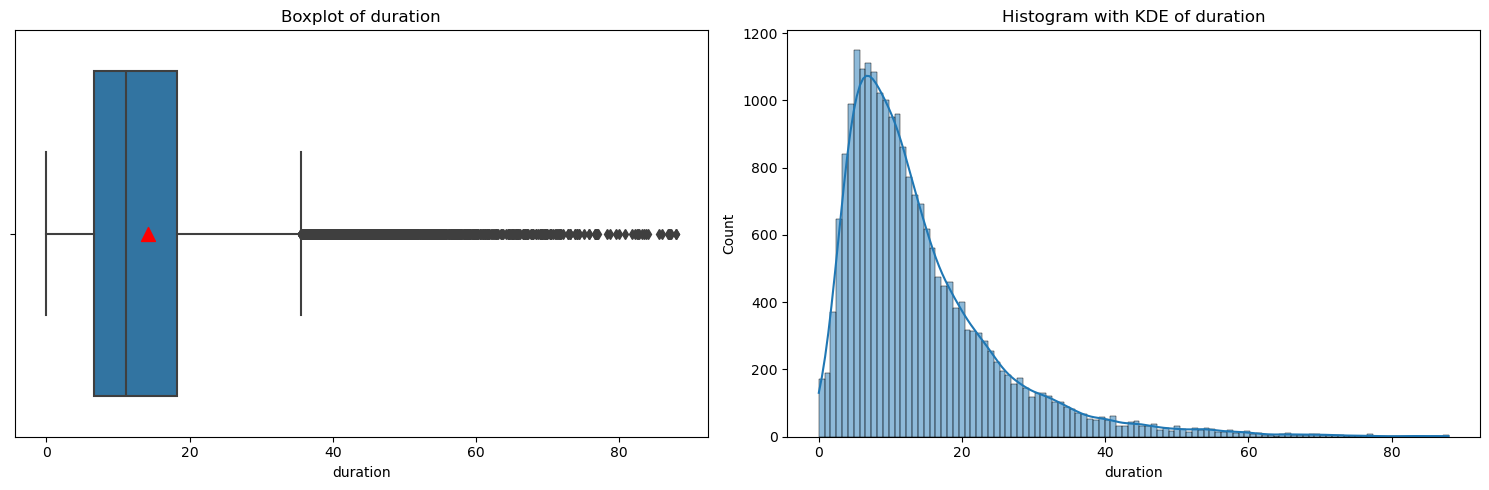

In [36]:
visualize_distribution(df, 'duration')

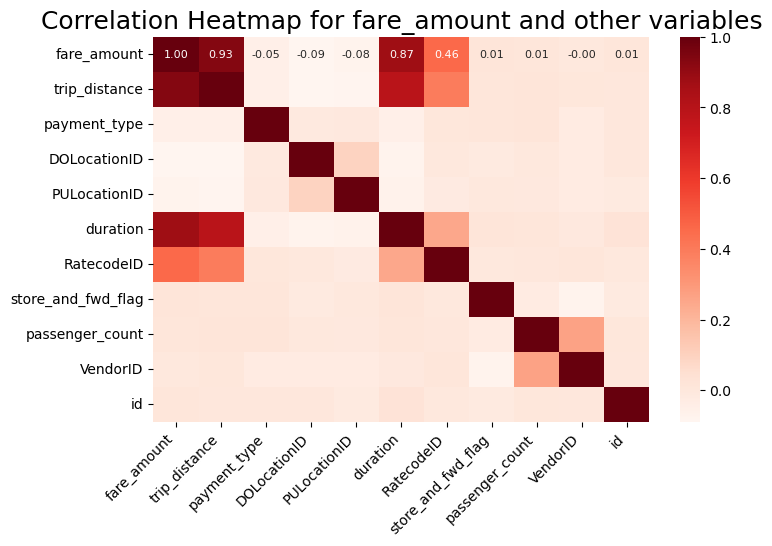

In [37]:

# List of columns to focus on, including 'fare_amount'
columns_of_interest = ['fare_amount', 'trip_distance', 'payment_type', 'DOLocationID', 'PULocationID', 'duration', 
                       'RatecodeID', 'store_and_fwd_flag', 'passenger_count', 'VendorID', 'id']  # Add other relevant columns as needed

# Create a subset of the DataFrame with these columns
df_subset = df[columns_of_interest]

# Increase the figure size for better readability
plt.figure(figsize=(8, 5))

# Create the heatmap with more suitable settings for better readability
sns.heatmap(df_subset.corr(method='pearson'), annot=True, cmap='Reds', fmt='.2f', annot_kws={"size": 8})

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Set the title with an increased font size
plt.title('Correlation Heatmap for fare_amount and other variables', fontsize=18)

# Display the heatmap
plt.show()


trip_distance, duration, ratecodeID are highly correlated with fare_amount

### Feature Engineering

When deployed, the model will not know the duration of a trip until after the trip occurs, so we cannot train a model that uses this feature. However, we can use the statistics of trips we know to generalize about ones we do not know.

create 2 columns called `mean_distance` and `mean_duration` that captures the **mean distance** and **mean duration** for each group of trips that share pickup and dropoff points.

In [38]:
df.head()

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,0,100,231,1,13.0,0.0,0.5,2.76,0.0,0.3,16.56,14.07
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,0,186,43,1,16.0,0.0,0.5,4.00,0.0,0.3,20.80,26.50
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,0,262,236,1,6.5,0.0,0.5,1.45,0.0,0.3,8.75,7.20
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,0,188,97,1,20.5,0.0,0.5,6.39,0.0,0.3,27.69,30.25
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,0,4,112,2,16.5,0.5,0.5,0.00,0.0,0.3,17.80,16.72


In [39]:

# Create `pickup_dropoff` column
df['pickup_dropoff'] = df['PULocationID'].astype(str) + ' ' + df['DOLocationID'].astype(str)


In [40]:
df['pickup_dropoff'].head()

0    100 231
1     186 43
2    262 236
3     188 97
4      4 112
Name: pickup_dropoff, dtype: object

In [41]:
# Create the `mean_distance` column using transform
df['mean_distance'] = df.groupby('pickup_dropoff')['trip_distance'].transform('mean')

# Create the `mean_duration` column using transform
df['mean_duration'] = df.groupby('pickup_dropoff')['duration'].transform('mean')

In [73]:
# Precompute means
mean_values = df.groupby('pickup_dropoff').agg({'trip_distance': 'mean', 'duration': 'mean'}).reset_index()
mean_values.columns = ['pickup_dropoff', 'mean_distance', 'mean_duration']

# Save to a CSV file
mean_values.to_csv('mean_values.csv', index=False)

In [43]:
# Confirm that it worked
df[(df['PULocationID'] == 100) & (df['DOLocationID'] == 231)][['mean_distance', 'mean_duration']]


,mean_distance,mean_duration
0,3.521667,22.848333
4909,3.521667,22.848333
16636,3.521667,22.848333
18134,3.521667,22.848333
19761,3.521667,22.848333
20581,3.521667,22.848333


In [44]:
df.head()

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,0,100,231,...,0.0,0.5,2.76,0.0,0.3,16.56,14.07,100 231,3.521667,22.848333
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,0,186,43,...,0.0,0.5,4.00,0.0,0.3,20.80,26.50,186 43,3.108889,24.470000
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,0,262,236,...,0.0,0.5,1.45,0.0,0.3,8.75,7.20,262 236,0.881429,7.250286
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,0,188,97,...,0.0,0.5,6.39,0.0,0.3,27.69,30.25,188 97,3.700000,30.250000
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,0,4,112,...,0.5,0.5,0.00,0.0,0.3,17.80,16.72,4 112,4.435000,14.620000


Create new columns, `pickup_day` (name of day), `pickup_hour` (hour of the day),  and `pickup_month` (name of month) by extracting the relevant information from the `tpep_pickup_datetime` column.

In [45]:
df['pickup_hour'] = df['tpep_pickup_datetime'].dt.hour
df['pickup_day_of_week'] = df['tpep_pickup_datetime'].dt.day_name().str.lower()
df['pickup_month'] = df['tpep_pickup_datetime'].dt.strftime('%b').str.lower()
df['pickup_day'] = df['tpep_pickup_datetime'].dt.day

In [46]:
df.head()

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,pickup_hour,pickup_day_of_week,pickup_month,pickup_day
0,24870114,2,2017-03-25 08:55:43,2017-03-25 09:09:47,6,3.34,1,0,100,231,...,0.3,16.56,14.07,100 231,3.521667,22.848333,8,saturday,mar,25
1,35634249,1,2017-04-11 14:53:28,2017-04-11 15:19:58,1,1.80,1,0,186,43,...,0.3,20.80,26.50,186 43,3.108889,24.470000,14,tuesday,apr,11
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,0,262,236,...,0.3,8.75,7.20,262 236,0.881429,7.250286,7,friday,dec,15
3,38942136,2,2017-05-07 13:17:59,2017-05-07 13:48:14,1,3.70,1,0,188,97,...,0.3,27.69,30.25,188 97,3.700000,30.250000,13,sunday,may,7
4,30841670,2,2017-04-15 23:32:20,2017-04-15 23:49:03,1,4.37,1,0,4,112,...,0.3,17.80,16.72,4 112,4.435000,14.620000,23,saturday,apr,15


Create `rush_hour` column

Create a binary `rush_hour` column that contains a 1 if the ride was during rush hour and a 0 if it was not.

In the US, rush hour typically occurs between 7:00 am and 9:00 am in the morning and 16:00 to 18:00 in the evening every weekday.

In [47]:
# Define rush hour time frames
morning_rush_hour = range(7, 10)
evening_rush_hour = range(16, 19)

# Create rush_hour column
df['rush_hour'] = 0  # Initialize with 0
# Set rush_hour to 1 if pickup hour falls within rush hour time frames on weekdays
df.loc[
    (
        (df['pickup_day_of_week'] != 'saturday') &
        (df['pickup_day_of_week'] != 'sunday') &
        (
            ((df['pickup_hour'].isin(morning_rush_hour)) & (df['pickup_hour'] < 10)) |
            ((df['pickup_hour'].isin(evening_rush_hour)) & (df['pickup_hour'] < 19))
        )
    ), 'rush_hour'
] = 1


In [48]:
df[df['rush_hour']==1].head()

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,...,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,pickup_hour,pickup_day_of_week,pickup_month,pickup_day,rush_hour
2,106203690,1,2017-12-15 07:26:56,2017-12-15 07:34:08,1,1.00,1,0,262,236,...,8.75,7.20,262 236,0.881429,7.250286,7,friday,dec,15,1
7,69059411,2,2017-08-15 17:41:06,2017-08-15 18:03:05,1,2.98,1,0,237,114,...,19.58,21.98,237 114,4.022500,26.437500,17,tuesday,aug,15,1
18,35388828,2,2017-04-10 18:12:58,2017-04-10 18:17:39,2,0.63,1,0,263,262,...,6.80,4.68,263 262,0.662143,4.577857,18,monday,apr,10,1
37,14373799,2,2017-02-23 08:04:57,2017-02-23 08:18:48,1,2.11,1,0,140,161,...,14.76,13.85,140 161,1.841429,14.057143,8,thursday,feb,23,1
42,103823476,2,2017-12-08 07:59:11,2017-12-08 08:15:32,1,4.52,1,0,116,239,...,19.30,16.35,116 239,4.520000,16.350000,7,friday,dec,8,1


c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


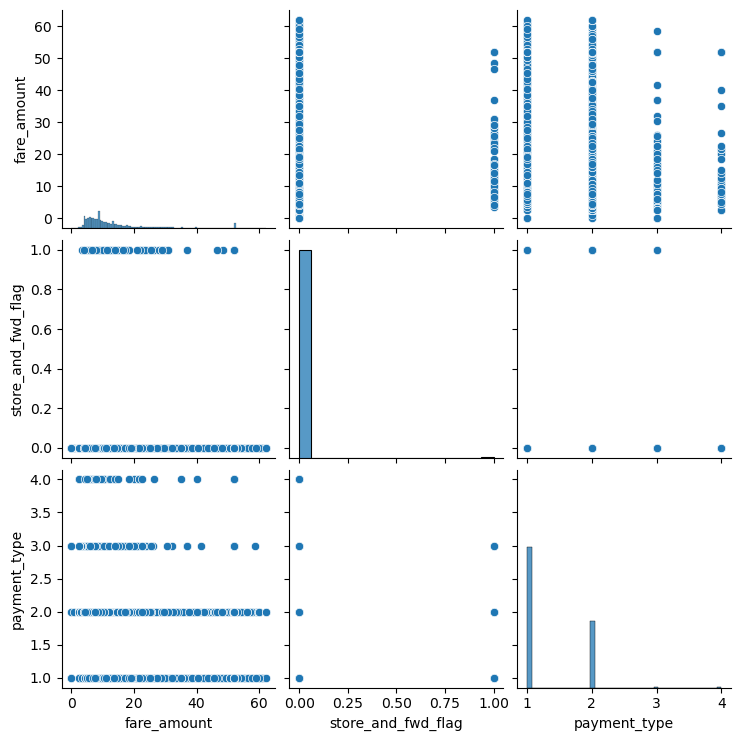

In [49]:
#pairplot of the dataframe
ax = sns.pairplot(df[['fare_amount', 'store_and_fwd_flag', 'payment_type']])
# Show the plot
plt.show()

c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\ProgramData\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

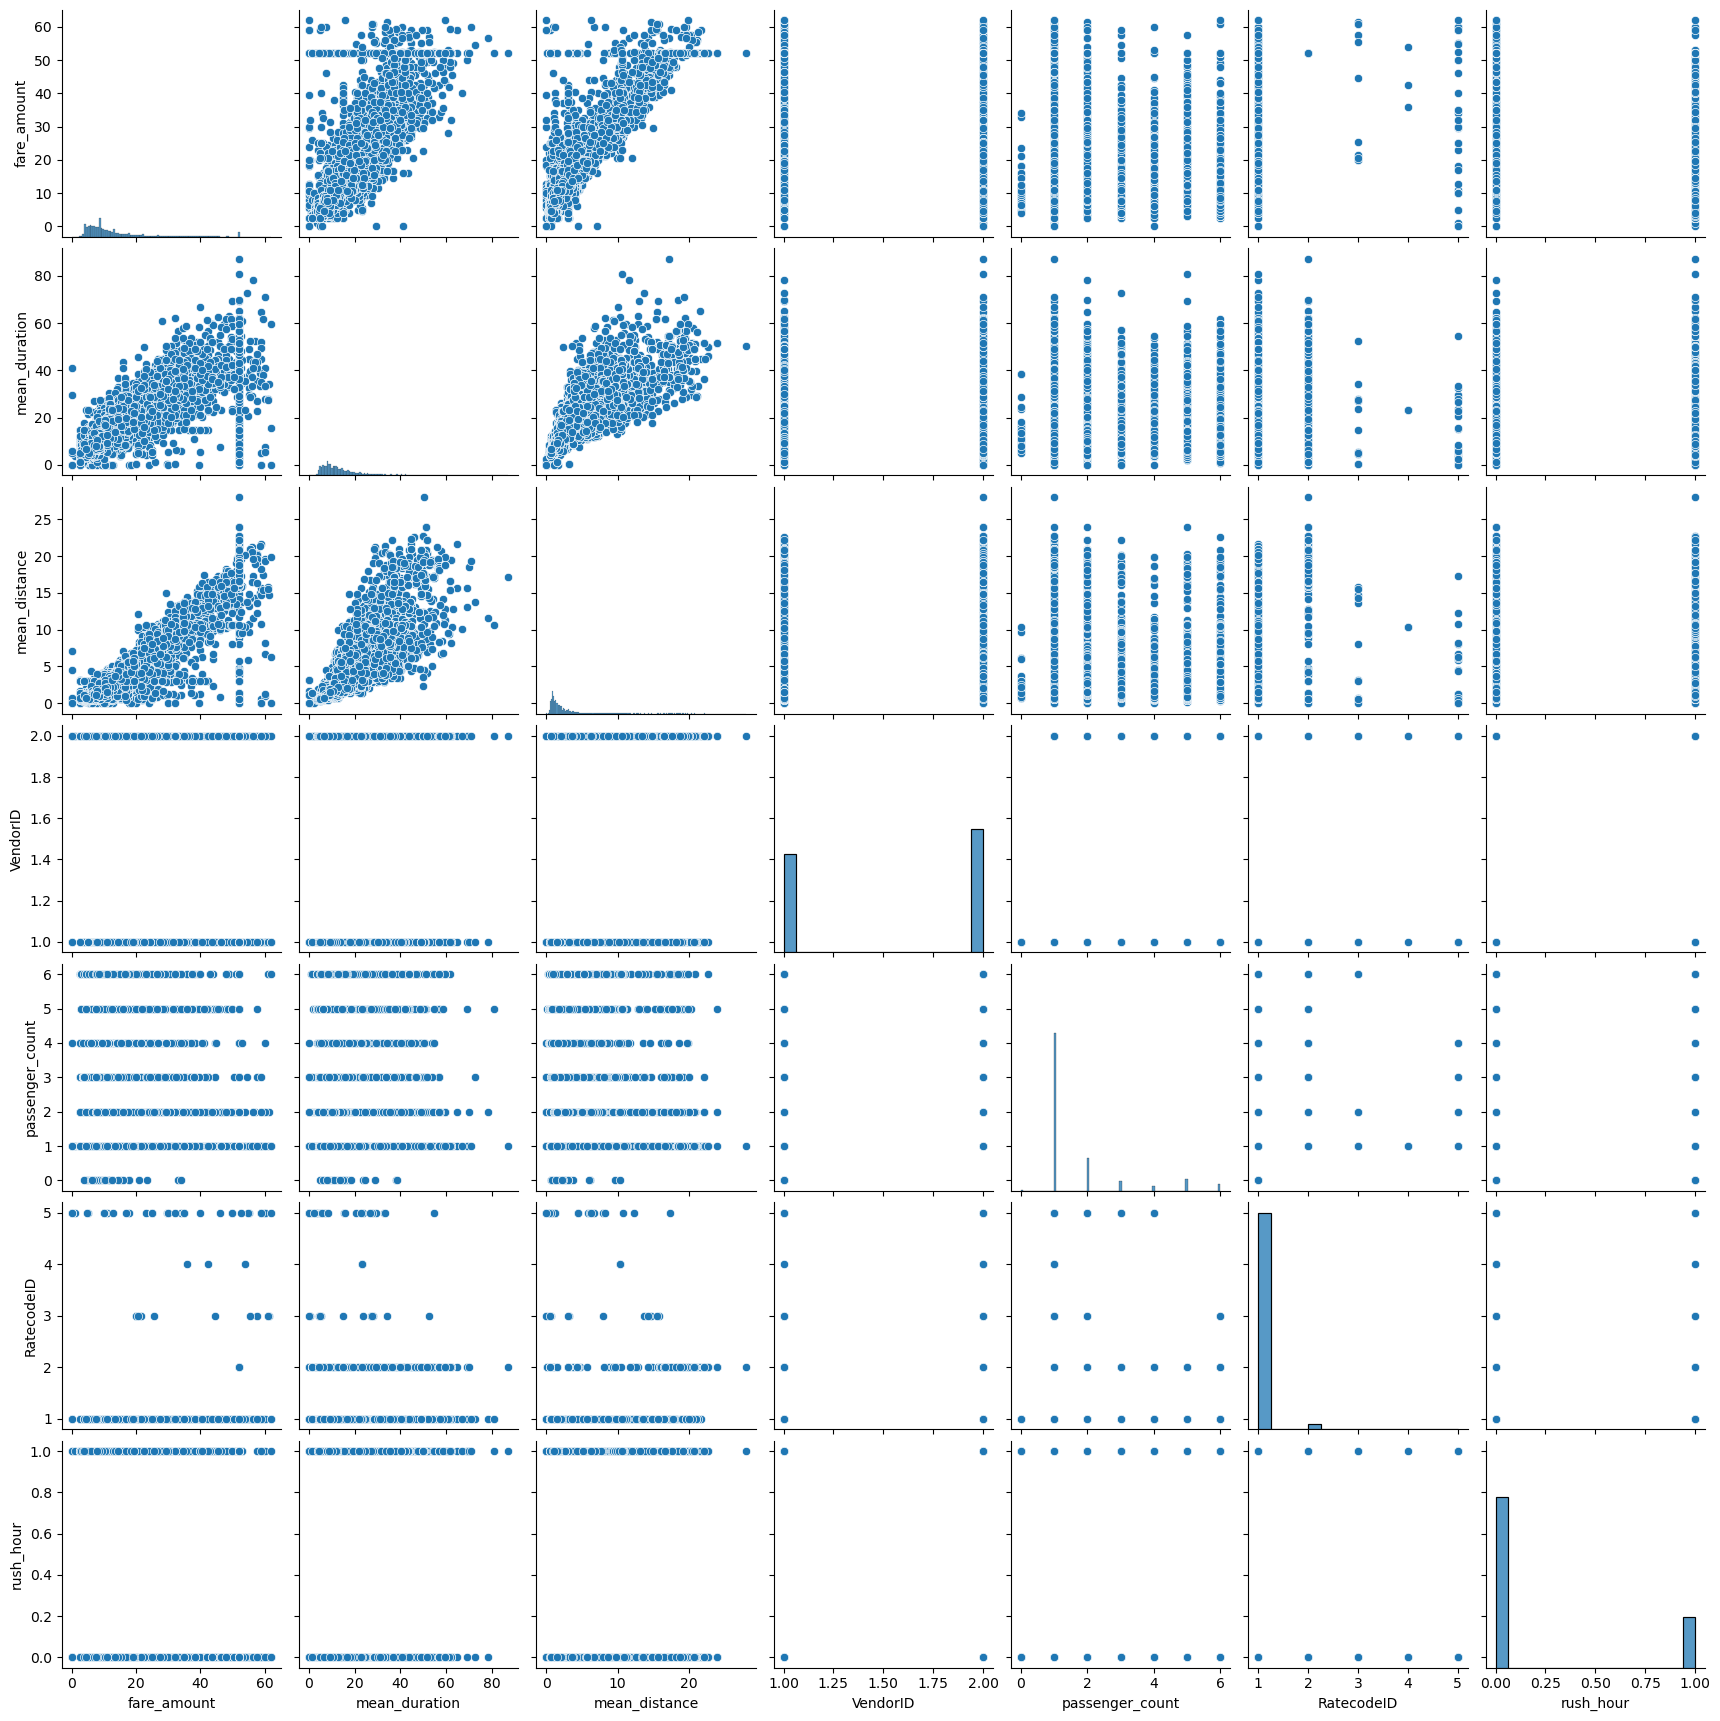

In [50]:
ax = sns.pairplot(df[['fare_amount', 'mean_duration', 'mean_distance', 'VendorID', 
                      'passenger_count','RatecodeID','pickup_dropoff','rush_hour']])
# Show the plot
plt.show()

The `mean_duration` and `mean_distance` variable correlates with the target variable. But what are the horizontal lines around fare amounts above $50? What are the values and how many are there?

Check the value of the rides in the horizontal line in the scatter plot.

In [51]:
df[df['fare_amount'] > 50]['fare_amount'].value_counts().head()

fare_amount
52.0    499
59.0      8
50.5      7
51.0      7
57.5      7
Name: count, dtype: int64

There are 514 trips whose fares were $52. 
lets examine them

In [52]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)
df[df['fare_amount']==52].head(20)

,id,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,duration,pickup_dropoff,mean_distance,mean_duration,pickup_hour,pickup_day_of_week,pickup_month,pickup_day,rush_hour
11,18600059,2,2017-03-05 19:15:30,2017-03-05 19:52:18,2,18.90,2,0,236,132,1,52.0,0.0,0.5,14.58,5.54,0.3,72.92,36.80,236 132,19.102000,30.844000,19,sunday,mar,5,0
110,47959795,1,2017-06-03 14:24:57,2017-06-03 15:31:48,1,18.00,2,0,132,163,1,52.0,0.0,0.5,0.00,0.00,0.3,52.80,66.85,132 163,19.229000,52.943000,14,saturday,jun,3,0
161,95729204,2,2017-11-11 20:16:16,2017-11-11 20:17:14,1,0.23,2,0,132,132,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,0.97,132 132,1.457500,1.368571,20,saturday,nov,11,0
247,103404868,2,2017-12-06 23:37:08,2017-12-07 00:06:19,1,18.93,2,0,132,79,2,52.0,0.0,0.5,0.00,0.00,0.3,52.80,29.18,132 79,19.431667,47.273333,23,wednesday,dec,6,0
379,80479432,2,2017-09-24 23:45:45,2017-09-25 00:15:14,1,17.99,2,0,132,234,1,52.0,0.0,0.5,14.64,5.76,0.3,73.20,29.48,132 234,17.654000,49.834000,23,sunday,sep,24,0
388,16226157,1,2017-02-28 18:30:05,2017-02-28 19:09:55,1,18.40,2,0,132,48,2,52.0,4.5,0.5,0.00,5.54,0.3,62.84,39.83,132 48,18.394000,56.719000,18,tuesday,feb,28,1
406,55253442,2,2017-06-05 12:51:58,2017-06-05 13:07:35,1,4.73,2,0,228,88,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,15.62,228 88,4.730000,15.620000,12,monday,jun,5,0
449,65900029,2,2017-08-03 22:47:14,2017-08-03 23:32:41,2,18.21,2,0,132,48,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,45.45,132 48,18.394000,56.719000,22,thursday,aug,3,0
468,80904240,2,2017-09-26 13:48:26,2017-09-26 14:31:17,1,17.27,2,0,186,132,2,52.0,0.0,0.5,0.00,5.76,0.3,58.56,42.85,186 132,17.096000,42.922000,13,tuesday,sep,26,0
520,33706214,2,2017-04-23 21:34:48,2017-04-23 22:46:23,6,18.34,2,0,132,148,1,52.0,0.0,0.5,5.00,0.00,0.3,57.80,71.58,132 148,17.994286,46.340000,21,sunday,apr,23,0


It seems that almost all of the trips in the first 30 rows where the fare amount was \$52 either begin or end at location 132, and all of them have a `RatecodeID` of 2.

- There is no readily apparent reason why Location 132 should have so many fares of 52 dollars. 
- They seem to occur on all different days, at different times, with both vendors, in all months. 
- However, there are many toll amounts of $5.76 and $5.54. 
- This would seem to indicate that location 132 is in an area that frequently requires tolls to get to and from.


The data dictionary says that `RatecodeID` of 2 indicates trips for JFK, which is John F. Kennedy International Airport.


### modeling variables

Drop features that are redundant, irrelevant, or that will not be available in a deployed environment.

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22536 entries, 0 to 22698
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   id                     22536 non-null  int64         
 1   VendorID               22536 non-null  int64         
 2   tpep_pickup_datetime   22536 non-null  datetime64[ns]
 3   tpep_dropoff_datetime  22536 non-null  datetime64[ns]
 4   passenger_count        22536 non-null  int64         
 5   trip_distance          22536 non-null  float64       
 6   RatecodeID             22536 non-null  int64         
 7   store_and_fwd_flag     22536 non-null  int64         
 8   PULocationID           22536 non-null  int64         
 9   DOLocationID           22536 non-null  int64         
 10  payment_type           22536 non-null  int64         
 11  fare_amount            22536 non-null  float64       
 12  extra                  22536 non-null  float64       
 13  mta_ta

In [54]:
df2 = df.copy()

df2 = df2.drop(['id', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'trip_distance', 'store_and_fwd_flag', 
                'PULocationID', 'DOLocationID', 'payment_type', 'extra', 'mta_tax', 'tip_amount', 'tolls_amount', 
                'improvement_surcharge', 'total_amount', 'tpep_dropoff_datetime', 'tpep_pickup_datetime', 'duration',
                'pickup_dropoff', 'pickup_hour', 'pickup_day', 'pickup_month', 'pickup_day_of_week'], axis=1)

df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22536 entries, 0 to 22698
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   VendorID         22536 non-null  int64  
 1   passenger_count  22536 non-null  int64  
 2   RatecodeID       22536 non-null  int64  
 3   fare_amount      22536 non-null  float64
 4   mean_distance    22536 non-null  float64
 5   mean_duration    22536 non-null  float64
 6   rush_hour        22536 non-null  int64  
dtypes: float64(3), int64(4)
memory usage: 1.4 MB


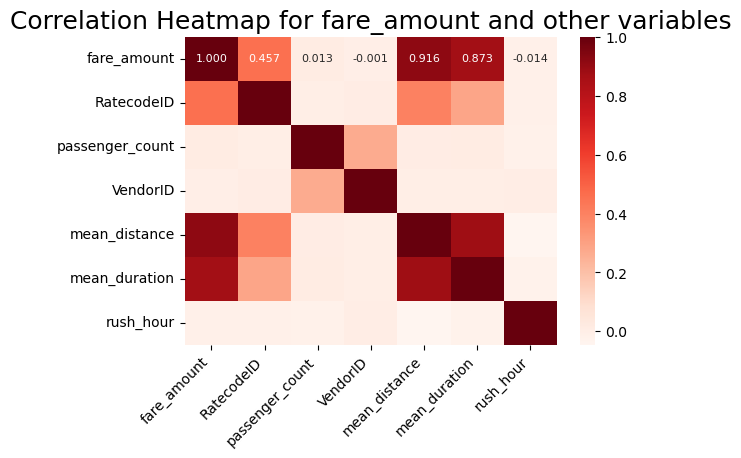

In [55]:
columns = ['fare_amount', 'RatecodeID', 'passenger_count', 'VendorID', 'mean_distance', 'mean_duration', 'rush_hour']
df2_subset = df2[columns]

plt.figure(figsize=(6, 4))
sns.heatmap(df2_subset.corr(method='pearson'), annot=True, cmap='Reds', fmt='.3f', annot_kws={"size": 8})
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Heatmap for fare_amount and other variables', fontsize=18)

plt.show()


## MODELLING

In [56]:
df2['VendorID'] = df2['VendorID'].astype(str)  # Convert VendorID to string for get_dummies

In [57]:
#Remove the target column from the features
X = df2.drop(columns=['fare_amount'])

#Set y variable
y = df2[['fare_amount']]

#Display first few rows
X.head()

,VendorID,passenger_count,RatecodeID,mean_distance,mean_duration,rush_hour
0,2,6,1,3.521667,22.848333,0
1,1,1,1,3.108889,24.470000,0
2,1,1,1,0.881429,7.250286,1
3,2,1,1,3.700000,30.250000,0
4,2,1,1,4.435000,14.620000,0


In [58]:
#one hot encode categorical variables
X = pd.get_dummies(X, drop_first=True)

In [59]:
X.head()

,passenger_count,RatecodeID,mean_distance,mean_duration,rush_hour,VendorID_2
0,6,1,3.521667,22.848333,0,True
1,1,1,3.108889,24.470000,0,False
2,1,1,0.881429,7.250286,1,False
3,1,1,3.700000,30.250000,0,True
4,1,1,4.435000,14.620000,0,True


In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=0)

In [61]:
def model_performance(model, predictors, target):
    """
    Function to compute different metrics to check regression model performance.

    model: Regressor model
    predictors: Independent variables
    target: Dependent variable
    """

    # Predict using the independent variables
    pred = model.predict(predictors)

    # Compute regression metrics
    mae = mean_absolute_error(target, pred)  # Mean Absolute Error
    mse = mean_squared_error(target, pred)  # Mean Squared Error
    rmse = mean_squared_error(target, pred, squared=False)  # Root Mean Squared Error
    r2 = r2_score(target, pred)  # R-squared score


    # Create a DataFrame of metrics
    df_perf = pd.DataFrame({
        "MAE": [mae],
        "MSE": [mse],
        "RMSE": [rmse],
        "R-squared": [r2] 
    })

    return df_perf


In [62]:

# Create and train the linear regression model
LRmodel = LinearRegression()
LRmodel.fit(X_train, y_train)


LinearRegression()

In [63]:
LRtrain = model_performance(LRmodel, X_train, y_train)
LRtrain

,MAE,MSE,RMSE,R-squared
0,2.082267,12.573898,3.545969,0.874451


In [64]:
LRtest = model_performance(LRmodel, X_test, y_test)
LRtest

,MAE,MSE,RMSE,R-squared
0,2.081246,12.8828,3.589262,0.874493


In [65]:
# Initialize the XGBoost regressor model
from xgboost import XGBRegressor

xgb_regressor = XGBRegressor()

# Training the XGBoost regressor model
xgb_regressor.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [66]:
xgbtrain = model_performance(xgb_regressor, X_train, y_train)
xgbtrain

,MAE,MSE,RMSE,R-squared
0,1.626141,5.998259,2.449134,0.940108


In [67]:
xgbtest = model_performance(xgb_regressor, X_test, y_test)
xgbtest

,MAE,MSE,RMSE,R-squared
0,1.941215,9.321351,3.053089,0.909189


## Residuals Analysis: Analyzed residuals to check for patterns and model fit.

#### xgb_regressor Model

In [68]:
# Make predictions on the test set
# Residual Analysis
y_pred_train = xgb_regressor.predict(X_train)
y_pred_test = xgb_regressor.predict(X_test)

Text(0.5, 1.0, 'Actual vs Predicted Fare Amount')

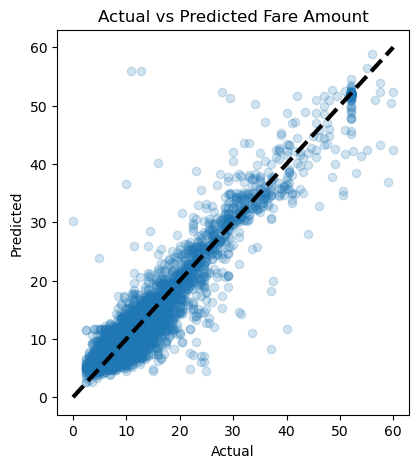

In [69]:
plt.figure(figsize=(10, 5))

# Scatter plot of actual vs predicted fare amount
plt.subplot(1, 2, 1)
plt.scatter(y_test, y_pred_test, alpha=0.2)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=3)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted Fare Amount')



Many points are close to the black dashed line, indicating that the model's predictions are close to the actual fare amounts.

There are some deviations from the line, especially for higher fare amounts, indicating discrepancies between actual and predicted values.

The model predicts lower fares more accurately, as indicated by the dense cluster of points along the ideal prediction line.

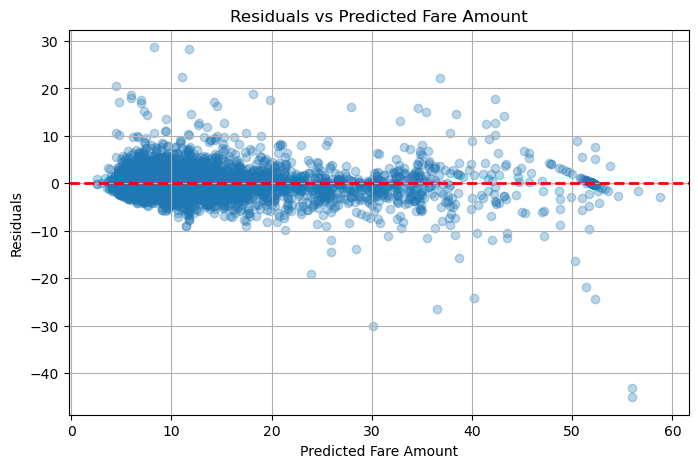

In [70]:
# Calculate residuals
residuals = y_test.values.reshape(-1, 1) - y_pred_test.reshape(-1, 1)

# Create a scatter plot of predicted values vs. residuals
plt.figure(figsize=(8, 5))
plt.scatter(y_pred_test, residuals, alpha=0.3)
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.xlabel('Predicted Fare Amount')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Fare Amount')
plt.grid(True)
plt.show()

The model's residuals are evenly distributed above and below zero

The residuals are mostly centered around zero, indicating that the model's predictions are generally unbiased.

As the predicted fare amount increases, the spread of the residuals also increases. This suggests that the model's predictions become less accurate for higher fare amounts.

#Save the trained model
#joblib.dump(best_xgb_model, 'best_xgb_model.pkl')

In [71]:
import pickle

In [72]:
# Save the model
with open('taxi_fare_model.pkl', 'wb') as file:
    pickle.dump(xgb_regressor, file)

# Save the columns for later use
with open('model_columns.pkl', 'wb') as file:
    pickle.dump(X.columns.tolist(), file)